198:533-NLP Final Project


The goal of this project is to explore some current NLP technologies, methodologies, and pipelines on a problem of my choice.
The problem that I have undertaken is the following: Can you predict which party won what state in 2018 (and by what margin)? The hypothesis is that by looking at tweets, you can classify them as liberal/conservative. The states that republicans won should have more significantly conservative tweets than the states that democrats won and vice versa. 


Methodology: 


Due to memory constraints and other (tweepy related) constraints, I have gathered only 5000 tweets from the current senate, 5000 tweets from the previous senate, and a kaggle dataset that contains an almost equal amount of tweets from democrats and republicans (approximately 86,000 tweets) from all different offices. The idea is to initially use 2 linear classifiers, the first which classifies the tweet as liberal/conservative and the second which look at how many tweets are liberal/conservative and gives a prediction on which party won that state. Then, the last linear classifer will be replaced with a multiclass classifier, that attempts to predict the state margin of victory (either +5D, +1-5D, +1-5R, or +5R)  
The second method will be to use an RNN with LSTM to classify the tweets as liberal/conservative, and then using a linear classifier to make a decision on what party won that state. Then, the last classifier will be replaced with a multiclass classifer that will attempt to predict the state margin of victory (either +5D, +1-5D, +1-5R, or +5R) like the baseline model.

In [1]:
import spacy
import string
import en_core_web_sm
import tweepy
import json
from tweepy import TweepError
import logging
import os
from pathlib import Path
import random
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import sklearn
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
import gensim.models.keyedvectors as word2vec
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import scipy.sparse as sp
from sklearn.multiclass import OneVsRestClassifier

C:\Users\xeshi\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
#Load the names of the senators, and their party affiliation
sen_names_file=open("senator_names.txt",'r')
sen=1
party=4
st=2
line_no=1
senators=[]
party_aff=[]
state_sen=[]
for line in sen_names_file:
    if len(line.strip())==0:
        continue
    if(line_no%sen==0):
        senators.append(line)
        sen=sen+4
    if(line_no%party==0):
        party_aff.append(line)
        party=party+4
    if(line_no%st==0):
        state_sen.append(line.split("Senate")[1])
        st=st+4
    line_no+=1
sen_names_file.close()

In [3]:
# get the twitter handles of the senators 
sen_twitter_handles=open("senator_handles.txt",'r')
twitter_handles=[]
for line in sen_twitter_handles:
    twitter_handles.append(line)
sen_twitter_handles.close()


In [4]:
# get the last name of the senators (this is how well match them to the twitter handles)
last_names=[]
for senator in senators:
    s=senator.split(" ")
    if len(s)==2:
        last_names.append(s[1])
    if len(s)==3:
        if s[0]=='Joe' or s[1]=='Casey':
            last_names.append(s[1])
        else:
            last_names.append(s[2])
    if len(s)==4:
        last_names.append(s[3])

In [5]:
# load the states in the US (50)
file=open('US_states.txt','r')
state=[]
for line in file:
    state.append(line)
    

In [6]:
# clean what was returned by removing the newlines, and putting text in lowercase if necessary
twitter_handles=[handle.replace('\n','') for handle in twitter_handles]
party_aff=[p.replace('\n','') for p in party_aff]
last_names=[name.replace('\n','').lower() for name in last_names]
state=[s.replace('\n','').strip() for s in state]
state_sen=[s.replace('\n','').strip() for s in state_sen]
handle_lower=[handle.lower() for handle in twitter_handles]

In [7]:
# create a dictionary of state and the corressponding senators twitter handles (initiall empty)
state_to_senators={k:[] for k in state}

In [8]:
# populate the dictionary with the twitter handles, and manually reset the incorrect mappings 
twitter_id=[]
for s in state:
    ind=[i for i, j in enumerate(state_sen) if j == s]
    sen_in_state=[last_names[ind[0]],last_names[ind[1]]]
    twitter_handles_in_state=[twitter_handles[i] for i,handle_lower in enumerate(handle_lower) for subs in sen_in_state if subs in handle_lower]
    for handle in twitter_handles_in_state:
        state_to_senators[s].append(handle)

state_to_senators["Florida"]=['@ScottforFlorida','@marcorubio']
state_to_senators["South Carolina"]=['@LindseyGrahamSC','@SenatorTimScott']
state_to_senators["Minnesota"]=[ '@TinaSmithMN','@amyklobuchar']
state_to_senators['Mississippi']=['@RogerWicker','@cindyhydesmith']
state_to_senators["Kentucky"].append('@Team_Mitch')

In [9]:
# remove the @ symbol from the twitter handles for tweepy to work 
for s in state_to_senators:
    for handle in state_to_senators[s]:
        twitter_id.append(handle.split('@')[1])

In [10]:
# load in the twitter keys for the Twitter API
key_file = 'keys.json'
with open(key_file) as f:
    keys = json.load(f)

In [11]:
# Testing connection with Twitter API and Developer Account 
try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: politics_res


In [12]:
# Various functions to help acquire tweets

def load_keys(path):
    json_data=open(path).read()
    data = json.loads(json_data)
    return data

def download_recent_tweets_by_user(user_account_name, keys):
    import tweepy
    tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, tweet_mode='extended').items(50)]
    return tweets;

def load_tweets(path):
    tweets = []
    with open(path, "r") as f:
        tweets = json.load(f)
    return tweets

def get_tweets_with_cache(user_account_name, keys_path,state): # need to add the state into here as well 
    data_path = 'data/'+state+"/"+user_account_name +'.json'
    if not Path(data_path).is_file():
        tweets = download_recent_tweets_by_user(user_account_name, load_keys(keys_path))
        with open(data_path, "w") as f: 
            json.dump(tweets, f)
        return tweets
            
    else:
        return load_tweets(data_path)

In [13]:
# Create folder for each state to store the tweets in 
for s in state:
    path = "data/"+s
    try:  
        os.mkdir(path)
    except OSError:  
        continue

In [14]:
# get the tweets and save them 
i=0
for state in state_to_senators:
    for handle in state_to_senators[state]:
        get_tweets_with_cache(twitter_id[i],key_file,state)
        i=i+1 

In [15]:
# State continues to be edited somehow in the above code , so just rerun this cell to reload states in correct format
file=open('US_states.txt','r')
state=[]
for line in file:
    state.append(line)
state=[s.replace('\n','').strip() for s in state]

In [16]:
# Get the current Senate's Tweets (2019) and drop the tuple of info into the all_tweets variable
path=os.getcwd()+"/data"
all_tweets=[]
i=0
for (dirname, dirs, files) in os.walk(path,topdown=True):
    for filename in files:
        tweets=load_tweets(path+"/"+state[i-1]+"/"+filename)
        name=filename.split(".")[0]
        state_name=state[i-1]
        for t in tweets:
            text=t['full_text']
            info=(name,text,state_name)
            all_tweets.append(info)
    i=i+1

In [17]:
# Loaded the previous Senates tweets (2016-2018)
path=os.getcwd()+"/tweet_training"
t2_tweets=[]
i=0
for (dirname,dirs,files) in os.walk(path,topdown=True):
    for filename in files:
        if "sorted" in filename:
            tweets=load_tweets(path+"/"+state[i-1]+"/"+filename)
            name=filename.split(".")[0]
            state_name=state[i-1]
            rand50=[random.randint(0,len(tweets)-1) for x in range(50)]
            for x in rand50:
                text=tweets[x]['full_text']
                info=(name,text,state_name)
                t2_tweets.append(info)
        else:
            continue
    i=i+1

In [18]:
# Format the current Senates Tweets into 3 lists so that they can be turned into DataFrames for verification
tweet_text=[]
author=[]
state=[]
for data in all_tweets:
    author.append(data[0])
    tweet_text.append(data[1])
    state.append(data[2])

In [19]:
# Convert the 3 lists into DataFrames for verification so far
df=pd.DataFrame({'Senator':author,'Tweet':tweet_text,'State of Senator': state})
df.head(5)

,Senator,Tweet,State of Senator
0,DougJones,Looks like The Late Show with Stephen Colbert ...,Alabama
1,DougJones,“I’ve introduced a bill – the Stop HATE Act – ...,Alabama
2,DougJones,I am so please to announce that Martin Luther ...,Alabama
3,DougJones,A great game indeed! Congrats and good luck t...,Alabama
4,DougJones,Louise and I are so proud of Carson - and he’s...,Alabama


In [20]:
# Read in the Kaggle Dataset, and compress it to just 2 columns of the relevant information (May need to add data here)
df2=pd.read_csv('training/tweets.csv')
training_df=pd.DataFrame({'Author':df2['handle'],"Tweet": df2['text']})
training_df.head(5)
df3=pd.read_csv('training_tweets.csv')
training_df2=pd.DataFrame({'Party':df3["Party"],'Tweet':df3["Tweet"]})
training_df2.head(5)

,Party,Tweet
0,Democrat,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RT @Vegalteno: Hurricane season starts on June...


In [21]:
# This is an NLTK tokenizer with stemming (dont know why i had to reimport the stopwords)
stopwords=set(stopwords.words('english'))
stopwords.add('/n')
ps=PorterStemmer()
worddict={}
def cleantweet(text):
    words=nltk.word_tokenize(text.lower())
    finish=[]
    for word in words:
        if word not in stopwords:
            if word.isalpha() or word.isnumeric():
                finish.append(ps.stem(word))
    return finish

In [22]:
# This is the spacy tokenizer
nlp = en_core_web_sm.load()
def cleantweetspacy(text):
    words=nlp.tokenizer(text.lower())
    finish=[]
    for word in words:
        if not word.is_stop:
            if word.is_alpha or word.is_digit:
                finish.append(word.lemma_)
    return finish

In [23]:
# This is aggregating the tweets together for a later processing step (combining them into one list)
# This also gets the target so that the supervised methods can be trained properly
combined_tweets=tweet_text
training_tweets=[]
target=[] # call 1 trump/conservative, call 0 hillary/liberal
for i in range(len(training_df2)): # this length is larger than the other set, so run 2 seperate loops for it 
    text=training_df2["Tweet"][i]
    combined_tweets.append(text)
    training_tweets.append(text)
    if training_df2["Party"][i]=='Democrat': # "Author", HillaryClinton
        target.append(0)
    else:
        target.append(1)

for j in range(len(t2_tweets)):
    text=t2_tweets[j][1]
    combined_tweets.append(text)

t2_tweets=[tweet[1] for tweet in t2_tweets]

In [24]:
# Count the number of distinct words to create a vector (Bag of Words approach)
for tweet in combined_tweets:
    tokens=cleantweet(tweet)
    for token in tokens:
        if token in worddict:
            worddict[token]=worddict[token]+1
        else:
            worddict[token]=1

In [25]:
# This will tell you how long the vector has to be for the BoW approach
vector_len=len(worddict)
print(vector_len)

43884


In [26]:
# In case of saving and resuming, do not have to run the entire notebook again 
with open('bow.json','w') as outfile:
    json.dump(worddict,outfile)

In [27]:
# function to create a bog of words based on the tweets (can swap out the NLTK tokenizer with spacy tokenizer here)
def bow(tweets,worddict,vector_len):
    bow=np.zeros((len(tweets),vector_len),dtype=np.int8) # memory on this is a problem,use smaller dataset with this method
    words=list(worddict.keys())
    for i in range(len(tweets)):
        tokens=cleantweet(tweets[i])
        vector=np.zeros((vector_len))
        for token in tokens:
            if token in words:
                vector[words.index(token)]=1
        bow[i,:]=vector
    return bow

In [28]:
# get the BOW for the kaggle dataset, the old senators, and the new senators (will take a few minutes to run!)
kaggle_train=bow(training_tweets,worddict,vector_len)
old_senators_bow=bow(t2_tweets,worddict,vector_len)
new_senators_bow=bow(tweet_text,worddict,vector_len)

In [29]:
# set the answers for the kaggle dataset for training 
target=np.array(target,dtype=np.int8)

In [30]:
# Initialize the two Linear classifiers for a baseline model (should not need import statement here)
leaning=SGDClassifier()
state_pred=SGDClassifier()

In [31]:
kaggle_train.shape

(86460, 43884)

In [32]:
kaggle_train=sp.csr_matrix(kaggle_train)

In [33]:
# Fit the first classifer on the first training data, looking to classify conservative/liberal tweets
leaning.fit(kaggle_train,target)

C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
# send through the old senator training data, get a prediction, and then use that data to train the second classifier
old_sen_class=leaning.predict(old_senators_bow)

In [35]:
# grab tweets 100 at a time, and turn them into tuples (num_con,num_lib) per state (can probably make this a function)
def tweettuples(predictions):
    vec2=[]
    for i in range(50):
        offset=i*100
        num_con=0
        for j in range(100):
            if predictions[offset+j]==1:
                num_con=num_con+1
        append=[num_con,100-num_con]
        vec2.append(append)
    return vec2


In [36]:
# get the tuples of (conservative,liberal)
old_sen_tuples=tweettuples(old_sen_class)
old_sen_tuples=np.array(old_sen_tuples)

In [37]:
# how each state voted in 2016 (manually entered in here)
actual_outcome_2016=[1,1,1,1,0,0,0,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1,1]
actual_outcome_2016=np.array(actual_outcome_2016)

In [38]:
# Fit the classifier with this training data 
state_pred.fit(old_sen_tuples,actual_outcome_2016)

C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
actual_outcome_2018=[1,1,0,1,0,0,0,0,1,1,0,1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0,1,0,1]
actual_outcome_2018=np.array(actual_outcome_2018)

In [40]:
# run the test data through the two classifiers and assess the accuracy
new_senators_bow=sp.csr_matrix(new_senators_bow)
new_sen_class=leaning.predict(new_senators_bow)
new_sen_tuples=tweettuples(new_sen_class)
new_sen_tuples=np.array(new_sen_tuples)
state_pred.score(new_sen_tuples,actual_outcome_2018)

0.8

(0, 100)

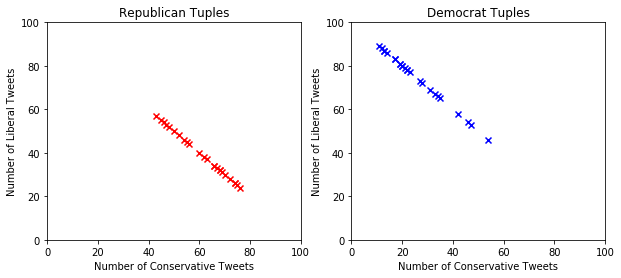

In [41]:
# PLot the data to see what was the problem with the classification (red is republican, blue is democrat)
x1=[]
y1=[]
x2=[]
y2=[]
for i in range(50):
    data=new_sen_tuples[i]
    if actual_outcome_2018[i]==1:
        x1.append(data[0])
        y1.append(data[1])
    else:
        x2.append(data[0])
        y2.append(data[1])

plt.figure(figsize=(10,4))
ax1=plt.subplot(1,2,1)
ax1.title.set_text("Republican Tuples")
ax1.set_ylabel("Number of Liberal Tweets")
ax1.set_xlabel("Number of Conservative Tweets")
plt.scatter(x1,y1,marker='x',color='r')
plt.ylim(0,100)
plt.xlim(0,100)
ax2=plt.subplot(1,2,2)
ax2.title.set_text("Democrat Tuples")
ax2.set_ylabel("Number of Liberal Tweets")
ax2.set_xlabel("Number of Conservative Tweets")
plt.scatter(x2,y2,marker='x',color='b')
plt.ylim(0,100)
plt.xlim(0,100)

The initial classifer is doing a pretty good job at classifying tweets as conservative or liberal, as evidenced by the accuracy score. I did find this accuracy to be pretty impressive and unexpected. The success of the BoW models suggests that indeed senators from different parties are using different words and language when talking to their constituents (as this is what the BoW method captures). It will be interesting to see what, if any difference the RNN can make in this process.

A good reason to consider an RNN in this approach is that the size of the data for BoW is impressively large (2.88 GB uncompressed). Hopefully, and RNN can make similar/better predictions using less data. 

In [42]:
# multiclass classifiers 1-5+ Democrat, 2= +1-5 Democrat, 3= +1-5 Republican, 4=5+ Republican
# manually inputted from 538 and CNN data 
multi_2016=[4,4,3,4,1,2,1,1,3,4,1,4,1,4,4,4,4,4,2,1,1,3,2,4,4,4,4,2,2,1,1,1,3,3,4,4,1,3,1,4,4,4,4,4,1,1,1,4,3,4]
multi_2018=[4,4,3,4,1,1,1,1,2,4,1,4,1,4,2,4,4,4,1,1,1,1,1,4,4,4,4,1,1,1,1,1,3,4,4,4,1,1,1,4,4,4,3,4,1,1,1,4,1,4]

In [43]:
# a simple multiclass classifier that will use SGD as the metric
state_pred_margin=OneVsRestClassifier(SGDClassifier())

In [44]:
state_pred_margin.fit(old_sen_tuples,multi_2016)

C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [93]:
state_pred_margin.score(new_sen_tuples,multi_2018)

0.86

In [94]:
pred=state_pred_margin.predict(new_sen_tuples)

In [133]:
agree=[]
for i in range(50):
    agree.append(pred[i]==multi_2018[i])

In [109]:
def converttotext(n):
    if n==1:
        return "Solid D (+5)"
    if n==2:
        return "Leans D (+1-5)"
    if n==3:
        return "Leans R (+1-5)"
    if n==4:
        return "Solid R (+5)"
pred_text=[]
actual_text=[]
for i in range(50):
    pred_text.append(converttotext(pred[i]))
    actual_text.append(converttotext(multi_2018[i]))

In [132]:
new_sen_tuples=tweettuples(new_sen_class)

In [134]:
output2=pd.DataFrame()
output2["State"]=state
output2["Tuples"]=new_sen_tuples
output2["Predicted"]=pred_text
output2["Actual"]=actual_text
output2["Agreement"]=agree
output2

,State,Tuples,Predicted,Actual,Agreement
0,Alabama,"[66, 34]",Solid R (+5),Solid R (+5),True
1,Alaska,"[55, 45]",Solid R (+5),Solid R (+5),True
2,Arizona,"[47, 53]",Solid R (+5),Leans R (+1-5),False
3,Arkansas,"[66, 34]",Solid R (+5),Solid R (+5),True
4,California,"[13, 87]",Solid D (+5),Solid D (+5),True
5,Colorado,"[42, 58]",Solid R (+5),Solid D (+5),False
6,Connecticut,"[13, 87]",Solid D (+5),Solid D (+5),True
7,Delaware,"[31, 69]",Solid D (+5),Solid D (+5),True
8,Florida,"[68, 32]",Solid R (+5),Leans D (+1-5),False
9,Georgia,"[70, 30]",Solid R (+5),Solid R (+5),True


In [135]:
with open("BoW.csv",'w') as outfile:
    output2.to_csv("BoW_Data.csv")

(0, 100)

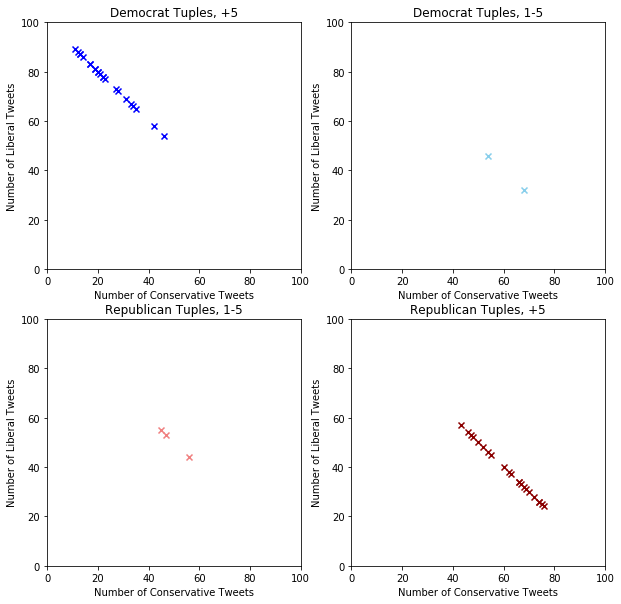

In [46]:
x1=[]
y1=[]
x2=[]
y2=[]
x3=[]
y3=[]
x4=[]
y4=[]
for i in range(50):
    data=new_sen_tuples[i]
    if multi_2018[i]==1:
        x1.append(data[0])
        y1.append(data[1])
    elif multi_2018[i]==2:
        x2.append(data[0])
        y2.append(data[1])
    elif multi_2018[i]==3:
        x3.append(data[0])
        y3.append(data[1])
    else:
        x4.append(data[0])
        y4.append(data[1])

plt.figure(figsize=(10,10))
ax1=plt.subplot(2,2,1)
ax1.title.set_text("Democrat Tuples, +5")
ax1.set_ylabel("Number of Liberal Tweets")
ax1.set_xlabel("Number of Conservative Tweets")
plt.scatter(x1,y1,marker='x',color='blue')
plt.ylim(0,100)
plt.xlim(0,100)
ax2=plt.subplot(2,2,2)
ax2.title.set_text("Democrat Tuples, 1-5")
ax2.set_ylabel("Number of Liberal Tweets")
ax2.set_xlabel("Number of Conservative Tweets")
plt.scatter(x2,y2,marker='x',color='skyblue')
plt.ylim(0,100)
plt.xlim(0,100)
ax3=plt.subplot(2,2,3)
ax3.title.set_text("Republican Tuples, 1-5")
ax3.set_ylabel("Number of Liberal Tweets")
ax3.set_xlabel("Number of Conservative Tweets")
plt.scatter(x3,y3,marker='x',color='lightcoral')
plt.ylim(0,100)
plt.xlim(0,100)
ax4=plt.subplot(2,2,4)
ax4.title.set_text("Republican Tuples, +5")
ax4.set_ylabel("Number of Liberal Tweets")
ax4.set_xlabel("Number of Conservative Tweets")
plt.scatter(x4,y4,marker='x',color='darkred')
plt.ylim(0,100)
plt.xlim(0,100)

This multiclass accuracy using SGD classifer as the estimator is surprising, but it again lends credence to the idea that senators from each party are talking about different things.

In [47]:
# Import the word2vec pretrained google news model for the next methodology
embed_map = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [48]:
# convert the tweets to vector data for the RNN to use
def getvec(word):
    if word not in embed_map.vocab:
        return embed_map['random'] # maybe need a better word to use 
    else:
        return embed_map[word]
def tweettovec(tweets):
    all_vec=[]       
    for i in range(len(tweets)):
        tokens=cleantweetspacy(tweets[i]) # can use the spacy module here and see if there is improvement
        tweet_vec=[]
        for token in tokens:
            vec=getvec(token)
            tweet_vec.append(vec)
        all_vec.append(tweet_vec)
    return all_vec

In [49]:
training_tweets=[]
target_training=[]
for i in range(len(training_df2)):
    training_tweets.append(training_df2["Tweet"][i])
    if training_df2["Party"][i]=="Democrat":
        target_training.append(0)
    else:
        target_training.append(1)

In [50]:
# Convert the tweets into lists of vectors for each word (using the 300 length word embedding)
kaggle_vec=tweettovec(training_tweets)
old_sen_vec=tweettovec(t2_tweets)
new_sen_vec=tweettovec(tweet_text)

In [51]:
# Convert the data to numpy array for RNN input. Note: want to change the 44 to the max number of token in a tweet in any of
# the datasets used
def tonparray(tweet_vec):
    data=np.zeros((len(tweet_vec),44,300))
    for i in range(len(tweet_vec)):
        for j in range(len(tweet_vec[i])):
            data[i][43-j][:]=tweet_vec[i][j]
    return data

In [52]:
# get numpy array with the relevant data, padded with zeros when necessary
kaggle_final_data=tonparray(kaggle_vec)
old_sen_final_data=tonparray(old_sen_vec)
new_sen_final_data=tonparray(new_sen_vec)

In [53]:
kaggle_final_data.shape

(86460, 44, 300)

In [54]:
# RNN in Keras, using a simple 1 layer LSTM, and having one Dense layer (still working out how to optimize these parameters)
model = Sequential()
model.add(LSTM((8),batch_input_shape=(None,44,300),return_sequences=True))
model.add(LSTM((8)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 44, 8)             9888      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 10,441
Trainable params: 10,441
Non-trainable params: 0
_________________________________________________________________


In [56]:
# train this initial RNN-LSTM with the kaggle data, using 5 epochs (runthroughs), batch size is the entire dataset
results=model.fit(kaggle_final_data,target_training,epochs=5,verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 218s - loss: 0.2204 - acc: 0.6373
Epoch 2/5
 - 128s - loss: 0.2040 - acc: 0.6759
Epoch 3/5
 - 146s - loss: 0.1958 - acc: 0.6920
Epoch 4/5
 - 139s - loss: 0.1899 - acc: 0.7053
Epoch 5/5
 - 138s - loss: 0.1856 - acc: 0.7132


In [58]:
results=model.predict(old_sen_final_data)

In [59]:
def roundoff(results):
    for i in range(len(results)):
        if results[i]<0.5:
            results[i]=0
        else:
            results[i]=1
    return results

In [60]:
results=roundoff(results)
by_state=tweettuples(results)

In [61]:
state_pred.fit(by_state,actual_outcome_2016)

C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [62]:
test_set=model.predict(new_sen_final_data)

In [63]:
test_set=roundoff(test_set)
by_state_test=tweettuples(test_set)

In [64]:
state_pred.score(by_state_test,actual_outcome_2018)

0.82

(0, 100)

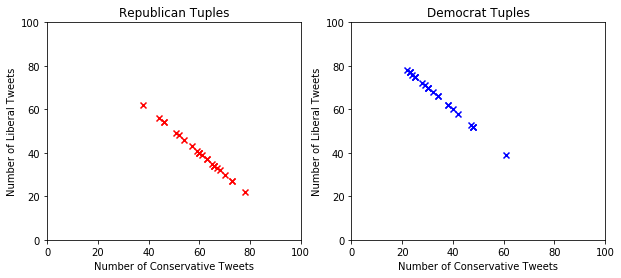

In [65]:
x1=[]
y1=[]
x2=[]
y2=[]
for i in range(50):
    data=by_state_test[i]
    if actual_outcome_2018[i]==1:
        x1.append(data[0])
        y1.append(data[1])
    else:
        x2.append(data[0])
        y2.append(data[1])

plt.figure(figsize=(10,4))
ax1=plt.subplot(1,2,1)
ax1.title.set_text("Republican Tuples")
ax1.set_ylabel("Number of Liberal Tweets")
ax1.set_xlabel("Number of Conservative Tweets")
plt.scatter(x1,y1,marker='x',color='r')
plt.ylim(0,100)
plt.xlim(0,100)
ax2=plt.subplot(1,2,2)
ax2.title.set_text("Democrat Tuples")
ax2.set_ylabel("Number of Liberal Tweets")
ax2.set_xlabel("Number of Conservative Tweets")
plt.scatter(x2,y2,marker='x',color='b')
plt.ylim(0,100)
plt.xlim(0,100)

In [66]:
state_pred_margin.fit(by_state,multi_2016)

C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\xeshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [67]:
state_pred_margin.score(by_state_test,multi_2018)

0.82

In [72]:
predictions=state_pred_margin.predict(by_state_test)

In [71]:
file=open('US_states.txt','r')
state=[]
for line in file:
    state.append(line)
state=[s.replace('\n','').strip() for s in state]

In [115]:
agree=[]
for i in range(50):
    agree.append(predictions[i]==multi_2018[i])

In [112]:
predictions_text=[]
for i in range(50):
    predictions_text.append(converttotext(predictions[i]))    

In [118]:
output=pd.DataFrame()
output["State"]=state
output["Tuple"]=by_state_test
output["Predicted"]=predictions_text
output["Actual"]=actual_text
output["Agreement"]=agree
output

,State,Tuple,Predicted,Actual,Agreement
0,Alabama,"[73, 27]",Solid R (+5),Solid R (+5),True
1,Alaska,"[46, 54]",Solid R (+5),Solid R (+5),True
2,Arizona,"[48, 52]",Solid R (+5),Leans R (+1-5),False
3,Arkansas,"[61, 39]",Solid R (+5),Solid R (+5),True
4,California,"[23, 77]",Solid D (+5),Solid D (+5),True
5,Colorado,"[47, 53]",Solid R (+5),Solid D (+5),False
6,Connecticut,"[23, 77]",Solid D (+5),Solid D (+5),True
7,Delaware,"[34, 66]",Solid D (+5),Solid D (+5),True
8,Florida,"[46, 54]",Solid R (+5),Leans D (+1-5),False
9,Georgia,"[66, 34]",Solid R (+5),Solid R (+5),True


In [119]:
with open("RNN_Data.csv",'w') as outfile:
    output.to_csv("RNN_Data.csv")

(0, 100)

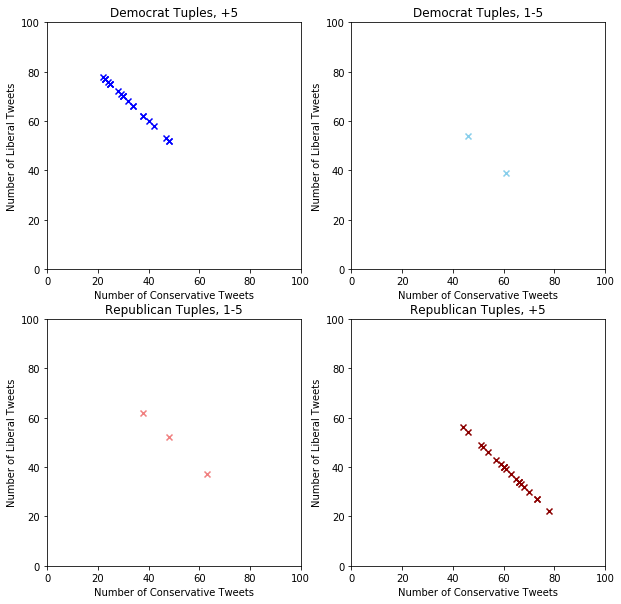

In [68]:
x1=[]
y1=[]
x2=[]
y2=[]
x3=[]
y3=[]
x4=[]
y4=[]
for i in range(50):
    data=by_state_test[i]
    if multi_2018[i]==1:
        x1.append(data[0])
        y1.append(data[1])
    elif multi_2018[i]==2:
        x2.append(data[0])
        y2.append(data[1])
    elif multi_2018[i]==3:
        x3.append(data[0])
        y3.append(data[1])
    else:
        x4.append(data[0])
        y4.append(data[1])

plt.figure(figsize=(10,10))
ax1=plt.subplot(2,2,1)
ax1.title.set_text("Democrat Tuples, +5")
ax1.set_ylabel("Number of Liberal Tweets")
ax1.set_xlabel("Number of Conservative Tweets")
plt.scatter(x1,y1,marker='x',color='blue')
plt.ylim(0,100)
plt.xlim(0,100)
ax2=plt.subplot(2,2,2)
ax2.title.set_text("Democrat Tuples, 1-5")
ax2.set_ylabel("Number of Liberal Tweets")
ax2.set_xlabel("Number of Conservative Tweets")
plt.scatter(x2,y2,marker='x',color='skyblue')
plt.ylim(0,100)
plt.xlim(0,100)
ax1=plt.subplot(2,2,3)
ax1.title.set_text("Republican Tuples, 1-5")
ax1.set_ylabel("Number of Liberal Tweets")
ax1.set_xlabel("Number of Conservative Tweets")
plt.scatter(x3,y3,marker='x',color='lightcoral')
plt.ylim(0,100)
plt.xlim(0,100)
ax2=plt.subplot(2,2,4)
ax2.title.set_text("Republican Tuples, +5")
ax2.set_ylabel("Number of Liberal Tweets")
ax2.set_xlabel("Number of Conservative Tweets")
plt.scatter(x4,y4,marker='x',color='darkred')
plt.ylim(0,100)
plt.xlim(0,100)

In [101]:
def sim_expt(test, p1, p2):
    '''apply test to a simulated experiment 
       where the difference between p1 and p2 is randomly erased'''
    bits = [random.getrandbits(1) for i in range(0, len(p1))]
    return test([p1[i] if bits[i] else p2[i] for i in range(0,len(p1))],
                [p2[i] if bits[i] else p1[i] for i in range(0,len(p1))])

def eval_diff(data, p1, p2) :
    '''a test generator based on the performance difference between p1 and p2
       asks whether the result of a simulated experiment is at least as extreme
       as the observed accuracy difference between p1 and p2 on data'''
    diff = abs(sklearn.metrics.accuracy_score(data, p1) -
               sklearn.metrics.accuracy_score(data, p2))
    def test_diff(n, m) :
        return (abs(sklearn.metrics.accuracy_score(data, n) - 
                    sklearn.metrics.accuracy_score(data, m)) >= 
                diff)
    return test_diff

def mcmcp_diff(data, p1, p2, k) :
    '''the approximate permuatation test:
       simulate an experiment like that used to obtain p1 and p2
       forgetting any difference between p1 and p2
       running the experiment k times
       and record the probability that the performance difference on data
       is as extreme as actually observed'''
    success = 0
    test = eval_diff(data, p1, p2)
    for i in range(0,k) :
        success += sim_expt(test, p1, p2)
    return success / float(k)

mcmcp_diff(multi_2018, predictions, pred, 2500) # actual, first pred, sec_pred, num_exp

0.4988

In [107]:
#print("Precision:", sklearn.metrics.precision_score(multi_2018, pred))
#print("Recall: ", sklearn.metrics.recall_score(multi_2018, pred))
print("Linear classification scores")
print("F1:", sklearn.metrics.f1_score(multi_2018, pred,average='macro'))
print("F1:", sklearn.metrics.f1_score(multi_2018, pred,average='micro'))
print("RNN evaluation scores")
print("F1:", sklearn.metrics.f1_score(multi_2018, predictions,average='macro'))
print("F1:", sklearn.metrics.f1_score(multi_2018, predictions,average='micro'))

Linear classification scores
F1: 0.4543226381461675
F1: 0.8599999999999999
RNN evaluation scores
F1: 0.43246869409660105
F1: 0.82
